In [6]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.linear_model import LinearRegression
import seaborn as sns
# sns.set_theme()
import math

matplotlib.use("pgf")
plt.rcParams['pgf.texsystem'] = "pdflatex"
plt.rcParams['savefig.format'] = 'pgf'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['font.size'] = 20
plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = "Helvetica"
n_colors = 10
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.viridis(np.linspace(0,0.8,n_colors)))


rng = np.random.default_rng(11)

In [17]:
# Monte Carlo Simulator for optimal trade execution
def sim_MC(funct, # function that determines # of shares to trade at each time step
           pos_args = [],
           key_args = {},
           T = 100, # total trading period
           lamb = 0.01, # magnitude of price impact
           gamma = 0.02, # std dev of alpha signal
           sigma = 0.1, # asset volatility
           c = 0.5, # concavity
           tau = 10, # impact decay
           theta = 5, # alpha decay
           init_q = 0, # initial position
           target_q = 1000, # target quantity
           S0 = 10, # initial price of asset
           n_MC = 1000, # no. of MC simulations
           ):
    '''
    Runs Monte Carlo simulations for optimal trade execution with price impact for a given trading strategy funct, then returns average of relevant quantities
    '''

    J = np.zeros((n_MC, T+1)) # EWMA of cumulative order flow
    I = np.zeros((n_MC, T+1)) # price impact
    Q = np.zeros((n_MC, T+1)) # position
    Y = np.zeros((n_MC, T+1)) # P&L
    alpha = np.zeros((n_MC, T)) # forecast
    S = np.zeros((n_MC, T+1)) # fundamental asset price (w/o trading)
    P = np.zeros((n_MC, T+1)) # price with impact
    x = np.zeros((n_MC, T)) # quantity to trade between t and t+1

    # Initialize starting values
    Q[:,0] = init_q
    Y[:,0] = init_q * S0
    S[:,0] = S0
    P[:,0] = S0
    
    # key_args['tot_q'] = end_pos - init_pos
    # key_args['t_steps'] = T

    for i in range(T):
        if i == 0:
            alpha[:,i] = rng.normal(scale = gamma, size = n_MC)
        else:
            alpha[:,i] = np.exp(-1/theta) * alpha[:,i-1] + rng.normal(scale = gamma, size = n_MC)
        key_args['alpha'] = alpha[:,i]
        key_args['rem_q'] = target_q - Q[:,i]
        key_args['rem_t'] = T-i

        if i == T-1: # if at the last time step, need to reach target_q in next step
            x[:,i] = key_args['rem_q']
        else:
            # input function gives execution price as function of quantity,
            # need to know decay function, alpha, how long it decays
            x[:,i] = funct(*pos_args, **key_args)

        # Update variables
        J[:,i+1] = np.exp(-1/tau) * J[:,i] + x[:,i]
        if c == 0.5:
            I[:,i+1] = lamb * np.sign(J[:,i+1]) * np.sqrt(abs(J[:,i+1]))
        else:
            I[:,i+1] = lamb * np.sign(J[:,i+1]) * abs(J[:,i+1]) ** c
        S[:,i+1] = S[:,i] + alpha[:,i] + rng.normal(scale = sigma, size = n_MC)
        P[:,i+1] = S[:,i+1] + I[:,i+1]
        Q[:,i+1] = Q[:,i] + x[:,i]
        Y[:,i+1] = Y[:,i] - x[:,i] * P[:,i] + Q[:,i+1] * (S[:,i+1]-S[:,i])
        

    # Take mean over all MC simulations
    avg_x = np.mean(x, axis = 0)
    avg_Q = np.mean(Q, axis = 0)
    avg_Y = np.mean(Y, axis = 0)
    avg_alpha = np.mean(alpha, axis = 0)
    avg_J = np.mean(J, axis = 0)
    # avg_I = np.mean(I, axis = 0)
    avg_I = lamb * np.sign(avg_J)* abs(avg_J)**c
    avg_S = np.mean(S, axis = 0)
    avg_P = avg_S + avg_I
    
    
    data = pd.DataFrame({
        'J': avg_J,
        'I': avg_I,
        'S': avg_S,
        'P': avg_P,
        'Q': avg_Q,
        'Y': avg_Y,
        })
    data = pd.concat([data, pd.DataFrame({'x': avg_x, 'alpha': avg_alpha})], axis = 1)
    return data



# Plotter
def plot_results(f_title, df, save_fig = False, fpath = ""):
    '''
    Plot averages of MC sim with option to save fig
    '''
    
    # Create a figure and axis
    N = 7
    ncols = 2
    fig, axes = plt.subplots(ncols = ncols, nrows = math.ceil(N/ncols), layout='constrained', figsize=(8 * ncols, 6 * math.ceil(N/ncols)))

    # Columns to plot
    cols = ['Q', 'x', 'Y', 'J', 'I', 'alpha', 'S', 'P']
    ylabs = [r"\# of Shares", r"\# of Shares", r"P\&L (\$)", r"Cum. Order Flow", r"Price Impact", r"Price Signal", r"Price (\$)"]
    titles = [r"Position ($\mathbf{Q_t}$)", r"Shares Traded ($\mathbf{x_t}$)", r"P\&L ($\mathbf{Y_t}$)", r"EWMA of Cumulative Order Flow ($\mathbf{J_t}$)", r"Price Impact ($\mathbf{I_t}$)", r"Forecast ($\mathbf{\alpha_t}$)", r"Asset Price"]

    for i, j in enumerate(ylabs):
        r = i//ncols
        c = i%ncols
        if i < 6:
            axes[r,c].plot(df[cols[i]], ".-")
        else:
            axes[r,c].plot(df[cols[i]], ".-", label = r"$\mathbf{S_t}$")
            axes[r,c].plot(df[cols[i+1]], "v-", label = r"$\mathbf{P_t}$", c = 'blue')
            axes[r,c].legend()
            last_val = df[cols[i+1]].iloc[df[cols[i+1]].last_valid_index()]
            axes[r,c].text(df[cols[i+1]].last_valid_index() + 2, last_val, f'{last_val:.3f}', va='bottom')

        # Annotate value at last time step
        last_val = df[cols[i]].iloc[df[cols[i]].last_valid_index()]
        axes[r,c].text(df[cols[i]].last_valid_index() + 2, last_val, f'{last_val:.3f}', va='bottom')
        
        axes[r,c].set_xlabel("Time")
        axes[r,c].set_ylabel(j)
        axes[r,c].set_title(titles[i])

    fig.suptitle(f"{f_title}", fontsize=24, fontweight = "heavy")

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Adjust layout to prevent clipping of titles
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight')
    return fig


def plot_multi_results(f_title, df, ncols = 2, save_fig=False, fpath=""):
    '''
    Plot averages of multidimensional MC sim with option to save fig
    data is a dict
    '''

    # Create a figure and axis
    N = 7               
    ncols = 2
    fig, axes = plt.subplots(ncols = ncols, nrows = math.ceil(N/ncols), layout='constrained', figsize=(8 * ncols, 6 * math.ceil(N/ncols)))

    # Columns to plot
    cols = ['Q', 'x', 'Y', 'J', 'I', 'alpha', 'S', 'P']
    ylabs = [r"\# of Shares", r"\# of Shares", r"P\&L (\$)", r"Cum. Order Flow", r"Price Impact", r"Price Signal", r"Price (\$)"]
    titles = [r"Position ($\mathbf{Q_t}$)", r"Shares Traded ($\mathbf{x_t}$)", r"P\&L ($\mathbf{Y_t}$)", r"EWMA of Cumulative Order Flow ($\mathbf{J_t}$)", r"Price Impact ($\mathbf{I_t}$)", r"Forecast ($\mathbf{\alpha_t}$)", r"Asset Price"]

    # if want to plot only P and not S
    # for i, c in enumerate(ylabs):
    #     leg_labels = []
    #     for p in df.keys():
    #         axes[i//2, i%2].plot(df[p][cols[i]], ".-", label = rf"$p={p:.2f}$")

    #         # Calculate final value
    #         final_val = df[p][cols[i]].iloc[len(df[p])-1]
    #         leg_labels.append(rf"$p={p:.2f}$, {final_val:.2f}")

    for i, j in enumerate(ylabs):
        r = i//ncols
        c = i%ncols
        lines = []
        leg_labels = []
        for p in df.keys():
            if i < 6:
                l, = axes[r,c].plot(df[p][cols[i]], ".-", label = rf"$p={p:.2f}$")

                # Calculate final value
                final_val = df[p][cols[i]].iloc[df[p][cols[i]].last_valid_index()]
            else:
                axes[r,c].plot(df[p][cols[i]], ".-", label = rf"$p={p:.2f}$")
                l, = axes[r,c].plot(df[p][cols[i+1]], "v-", c = axes[r, c].lines[-1].get_c(), label = rf"$p={p:.2f}$")

                # Calculate final value of P
                final_val = df[p][cols[i+1]].iloc[df[p][cols[i+1]].last_valid_index()]

            lines.append(l)
            leg_labels.append(rf"$p={p:.2f}$, {final_val:.3f}")

        axes[r,c].set_xlabel("Time")
        axes[r,c].set_ylabel(j)
        axes[r,c].set_title(titles[i])
        if i < 5: axes[r,c].legend(lines, leg_labels, ncols = 2, prop = {'size': 12})
        elif i == 6:
            leg1 = axes[r,c].legend(lines, leg_labels, ncols = 2, prop = {'size': 12}, loc = 'lower left')
            axes[r,c].add_artist(leg1)
            handles = [Line2D([], [], marker=marker) for marker in ['.', 'v']]
            axes[r,c].legend(handles = handles, labels = [r'$S_t$', r'$P_t$'], prop = {'size': 15})
            
    # first create a dummy legend, so fig.tight_layout() makes enough space
    axes[0, 0].legend(handles=axes[0, 0].lines[:1], bbox_to_anchor=(0, 1.12), loc='lower left')
    fig.tight_layout(pad=3.0)

    # now create the real legend
    axes[0, 0].legend(handles=axes[0, 0].lines, ncols = len(df.keys()), bbox_to_anchor=(1.03, 1.12), loc='lower center', fontsize=18)

    final_Y = np.array([df[x]['Y'].iloc[-1] for x in df.keys()])
    axes[(i+1)//ncols, (i+1)%ncols].plot(df.keys(), final_Y, 'o-')
    axes[(i+1)//ncols, (i+1)%ncols].set_title(r"Final P\&L for Varying $p$ values")
    axes[(i+1)//ncols, (i+1)%ncols].set_xlabel(r"$\mathbf{{p}}$")
    axes[(i+1)//ncols, (i+1)%ncols].set_ylabel(r"P\&L")

    fig.suptitle(f"{f_title}", fontsize=24, fontweight="heavy")

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Adjust layout to prevent clipping of titles
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight')

    return fig

## Constant x (p=0) {-}

/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_10346/4159925513.py:130: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


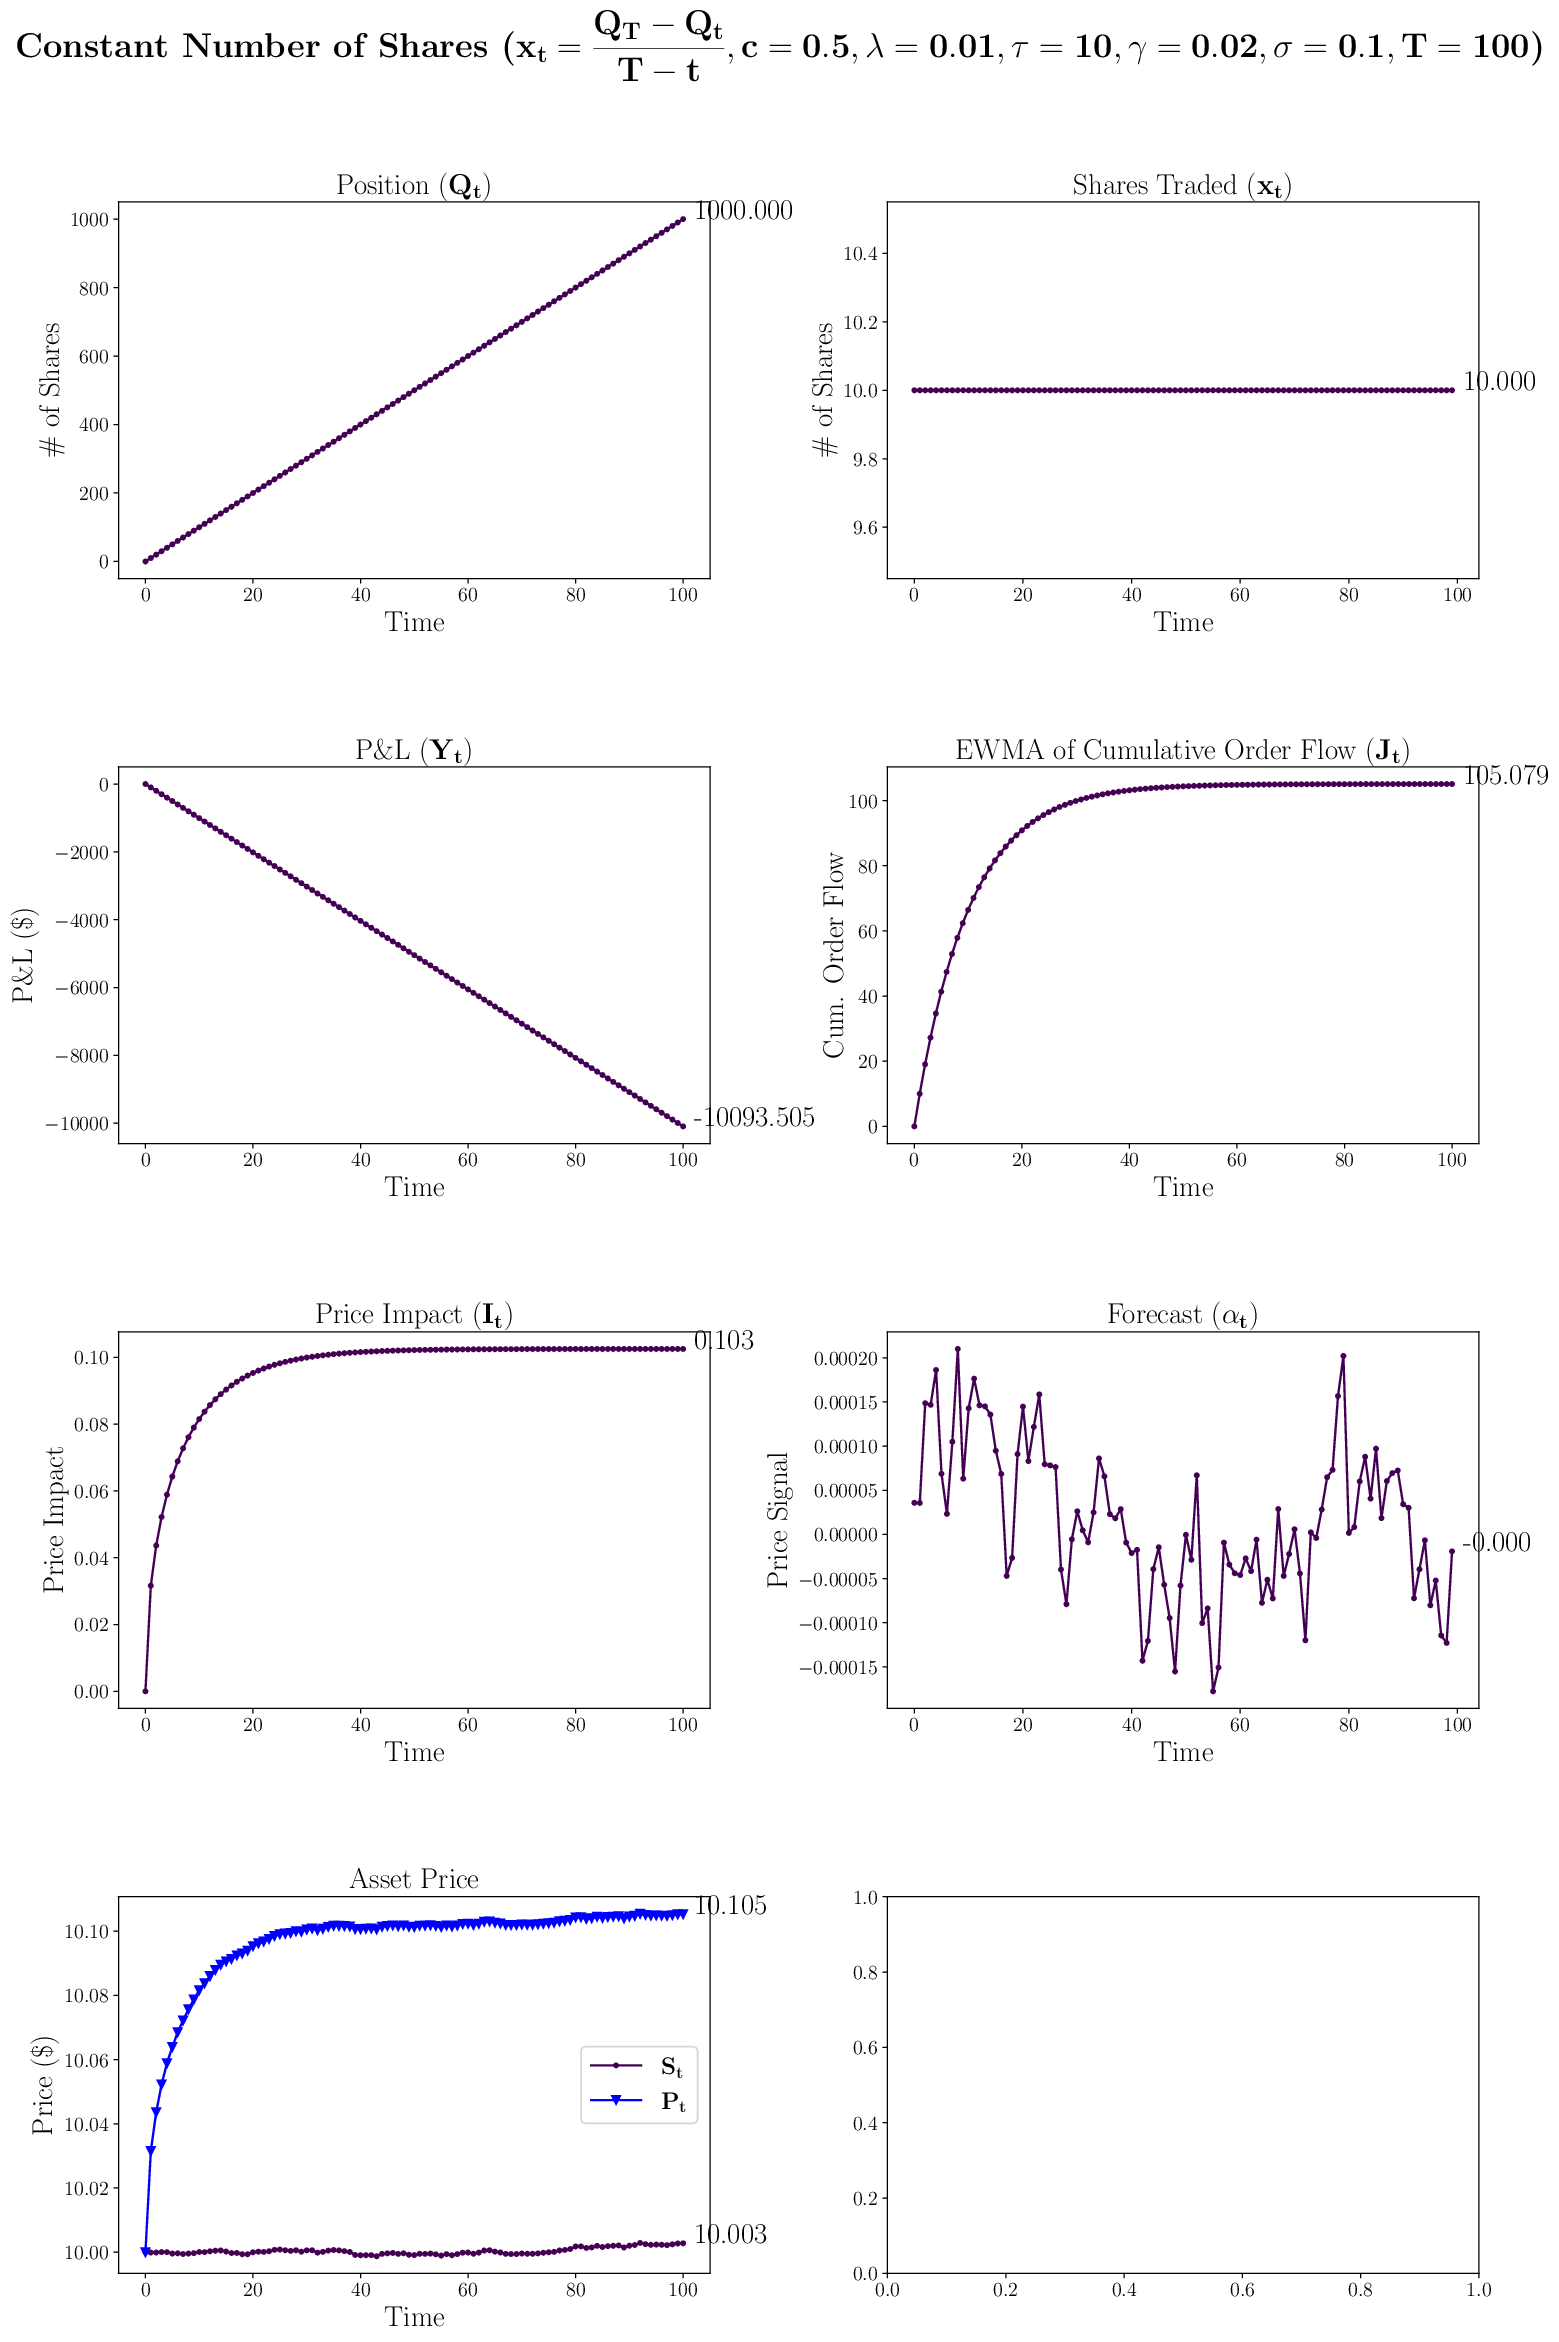

In [14]:
def const_x(rem_q, rem_t, **kwargs):
    '''
    Calculates number of shares to trade at each time step so that it's constant throughout the entire trading period.
    Takes in remaining quantity and remaining number of time steps
    '''
    assert 0 < rem_t, "rem_t<0"
    return rem_q/rem_t

params = {
    'init_q': 0,
    'target_q': 1000,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 100_000,
}

df = sim_MC(const_x, **params)
plot_results(fr"Constant Number of Shares ($\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}},c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\gamma={params['gamma']},\sigma={params['sigma']}, T={params['T']}}}$)", df, save_fig = False, fpath = "10.pgf")

## Constant Number of Shares With Alpha {-}

/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_10346/1452109496.py:201: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=3.0)
/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_10346/1452109496.py:215: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


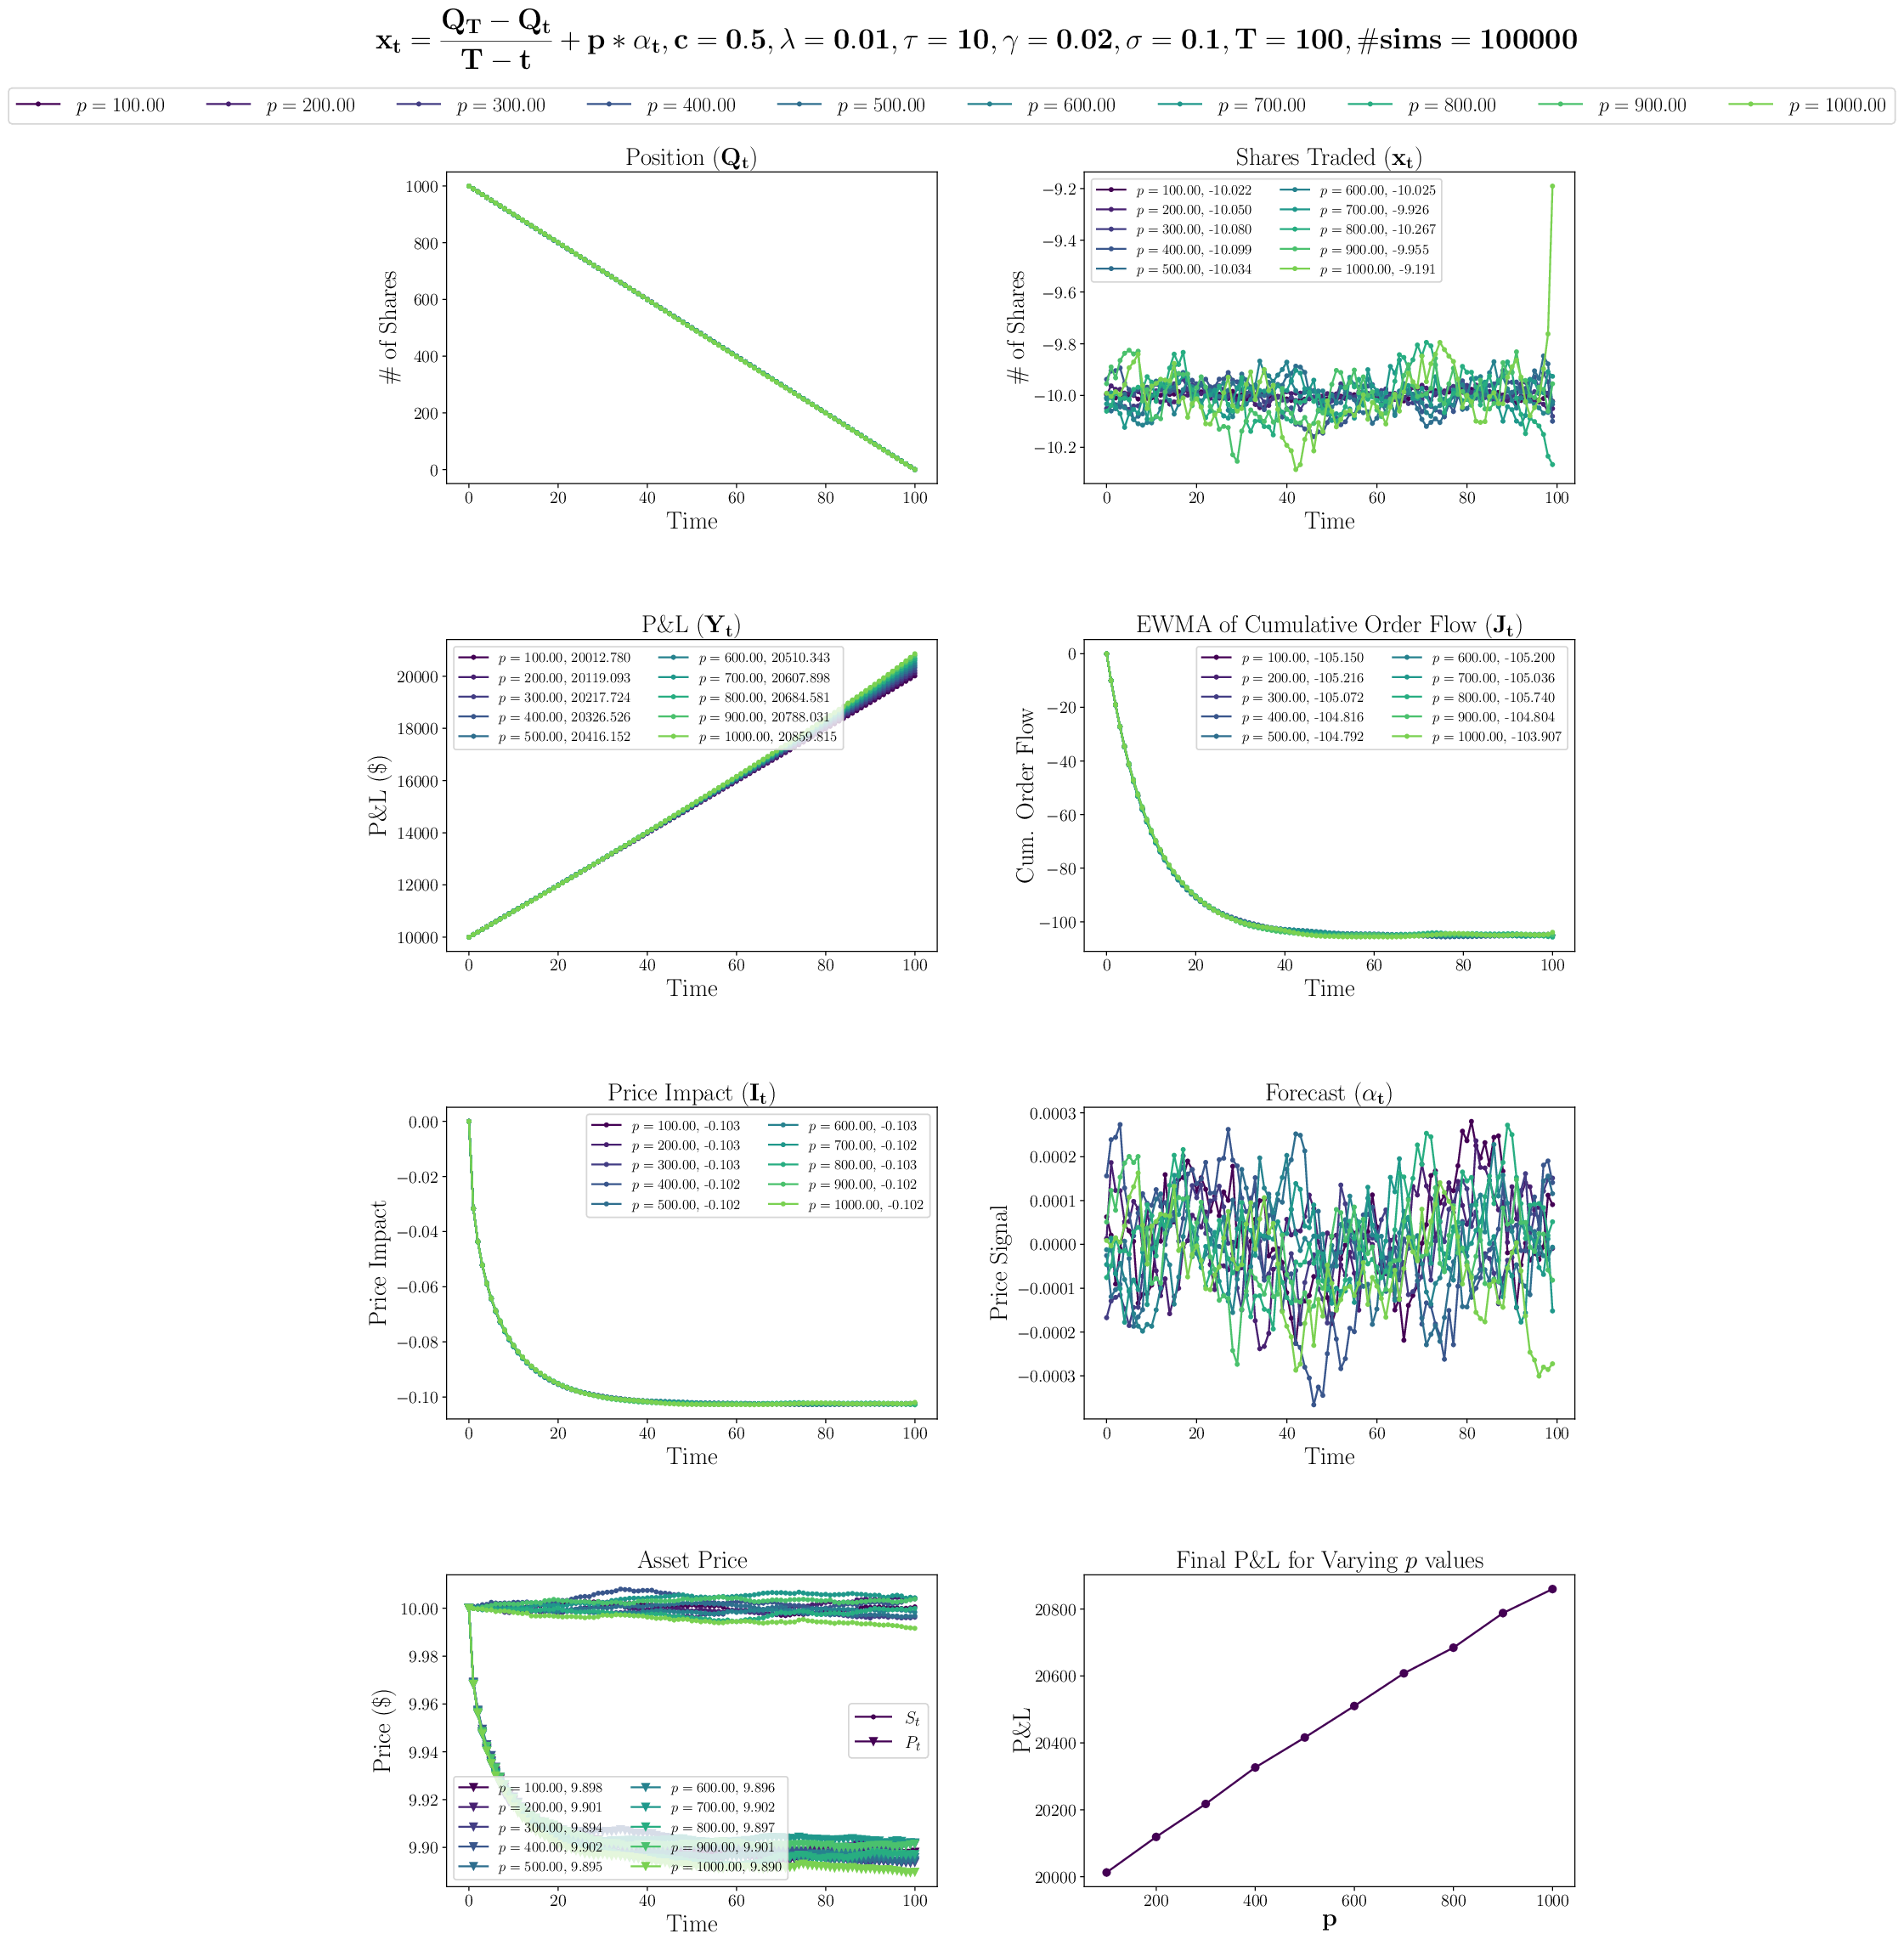

In [18]:
def const_num_alpha(p, rem_t, rem_q, alpha, **kwargs):
    '''
    Calculates the number of shares to trade for constant fraction plus alpha
    '''
    return rem_q/rem_t + p * alpha

d = {}
params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 100_000,
}

for i in range(1, 11):
    frac = 100 * i

    d[frac] = sim_MC(const_num_alpha, key_args = {'p': frac}, **params)

plot_multi_results(rf"$\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}}+p*\alpha_t,c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\gamma={params['gamma']},\sigma={params['sigma']},T={params['T']},\#sims={params['n_MC']}}}$", d, save_fig=False, fpath = "constalph05")

/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_10346/1452109496.py:201: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=3.0)
/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_10346/1452109496.py:215: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


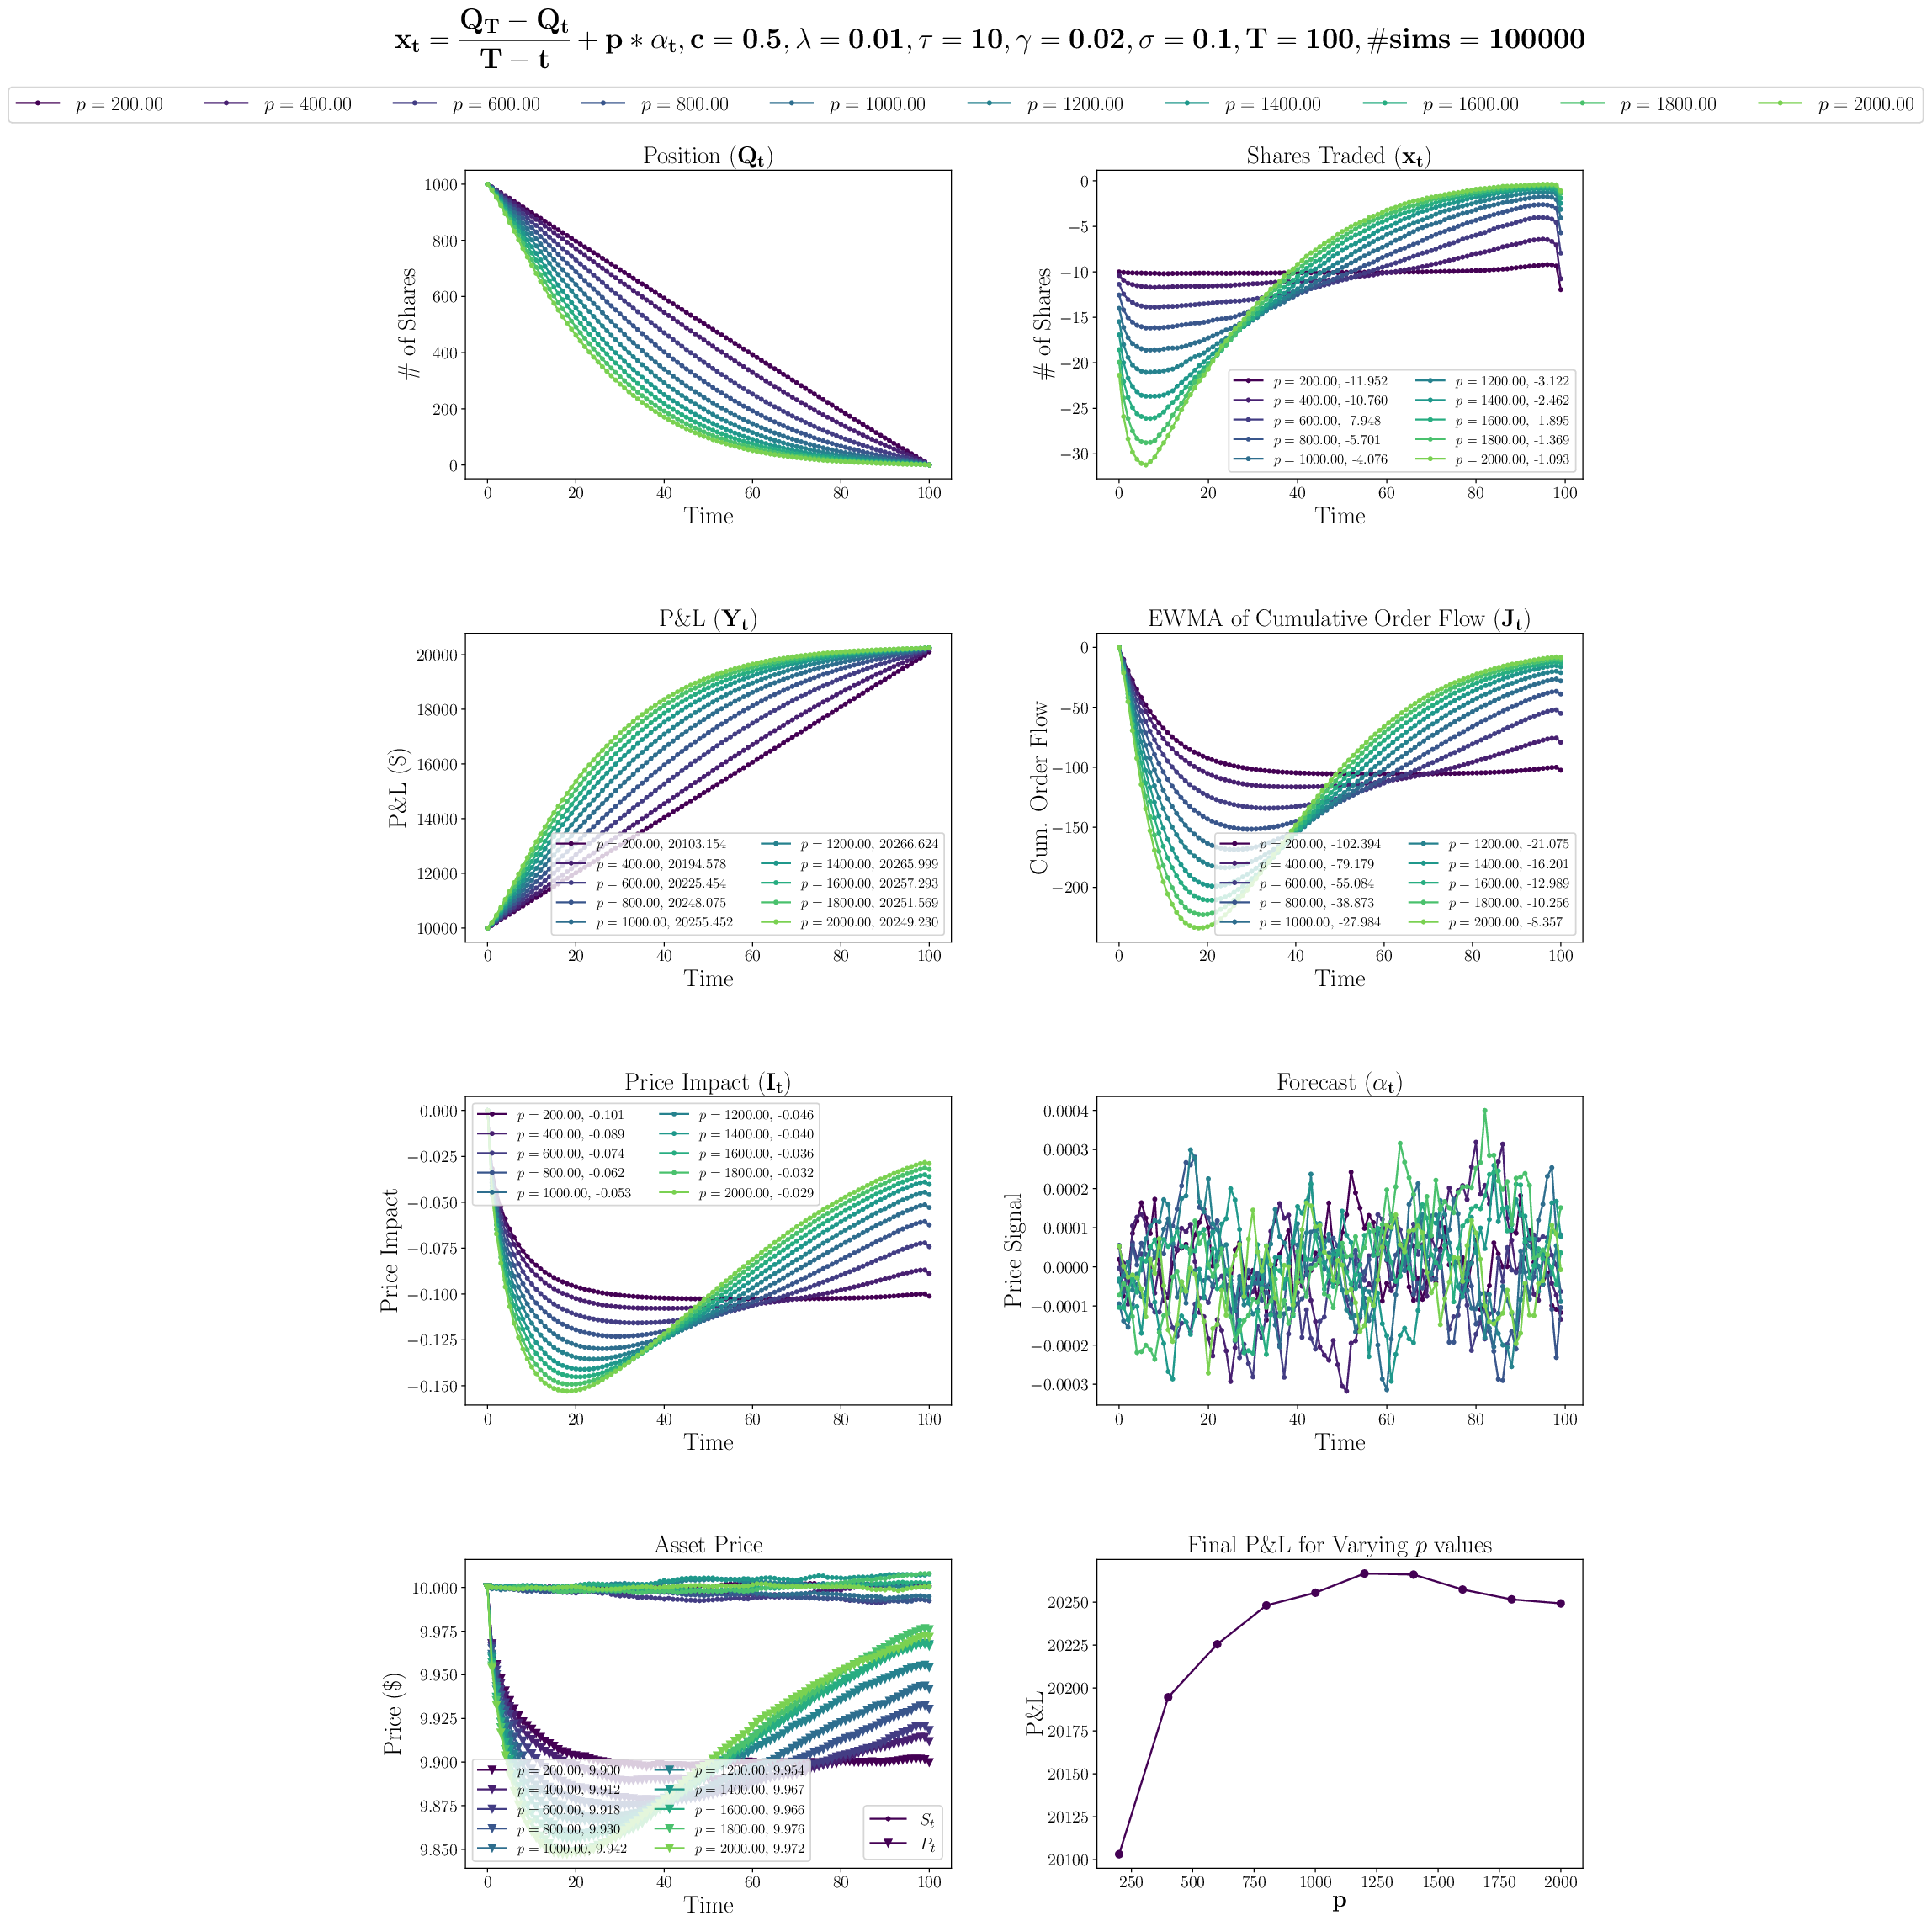

In [20]:
def const_num_alpha_only_buy(p, rem_t, rem_q, alpha, **kwargs):
    '''
    Calculates the number of shares to trade for constant fraction plus alpha (can only buy)
    '''
    x = np.maximum(rem_q/rem_t + p * alpha, 0)
    return np.minimum(x, rem_q)

def const_num_alpha_only_sell(p, rem_t, rem_q, alpha, **kwargs):
    '''
    Calculates the number of shares to trade for constant fraction plus alpha (can only sell)
    '''
    x = np.minimum(rem_q/rem_t + p * alpha, 0)
    return np.maximum(x, rem_q)

d = {}
params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 100_000,
}

for i in range(1, 11):
    frac = 200 * i

    d[frac] = sim_MC(const_num_alpha_only_sell, key_args = {'p': frac}, **params)

plot_multi_results(rf"$\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}}+p*\alpha_t,c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\gamma={params['gamma']},\sigma={params['sigma']},T={params['T']}, \# sims={params['n_MC']}}}$", d, save_fig=False, fpath = "constalph05")


In [22]:
d = {}
params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'theta': 5,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 500_000,
}

p_vals = np.arange(1, 2001, 1)
for frac in p_vals:
    d[frac] = sim_MC(const_num_alpha_only_sell, key_args = {'p': frac}, **params)

plot_multi_results(rf"$\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}}+p*\alpha_t,c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\theta={params['theta']},\gamma={params['gamma']},\sigma={params['sigma']},T={params['T']}, \# sims={params['n_MC']}}}$", d, save_fig=False, fpath = "constalph05")

KeyboardInterrupt: 

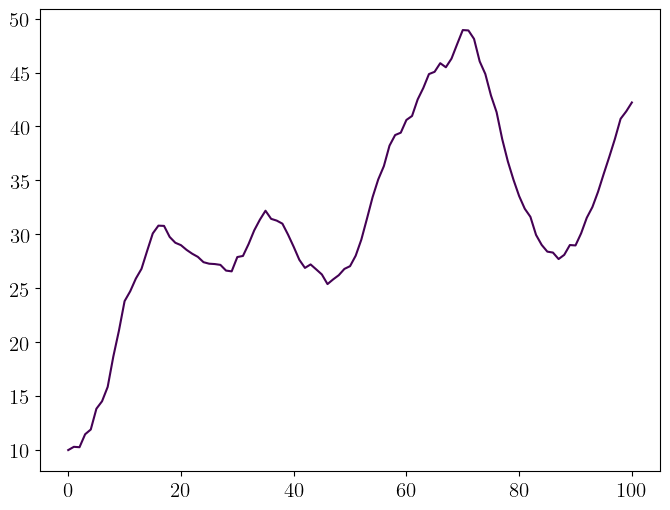

In [126]:
rw = np.zeros(101)
rw[0] = 10
a = 0
for i in range(100):
    a = np.exp(-1/10) * a + 0.5*rng.standard_normal()
    rw[i+1] = rw[i] + 0.3 * rng.standard_normal() + a
plt.plot(rw)

KeyboardInterrupt: 

In [96]:
max(d.keys())


1060